<a href="https://colab.research.google.com/github/Ashis-Palai/Porto-Seguro-Safe-s-Driver-Prediction/blob/main/Porto_Seguros_Safe_Driver_prediction_Feature_Engineering_submitted_file.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from numpy import mean
from sklearn.feature_selection import RFE

In [ ]:
train_data=pd.read_csv('train.csv')
test_data=pd.read_csv('test.csv')
print('Shape of train data set is :',train_data.shape)
print('Shape of test data set is :',test_data.shape)

Shape of train data set is : (595212, 59)
Shape of test data set is : (892816, 58)


## **1.Meta Data:**

In [ ]:
dict_={'ind':'Individual','reg':'registration','car':'Motor_Car','calc':'Calculated'}
meta_data=pd.DataFrame(columns=['column_name','type','use_of_column','data_type','category'])
meta_data['column_name']=train_data.columns
for i in meta_data.iterrows():
    if (i[1]['column_name'])=='id':
        (i[1]['use_of_column'])='user_id'
        (i[1]['data_type'])=((str(type(train_data['id'].values[0])).split('.')[-1]).split('>')[-2]).split("'")[-2]
        (i[1]['type'])='Categorical'
        (i[1]['category'])=None
    elif (i[1]['column_name'])=='target':
        (i[1]['use_of_column'])='output_target'
        (i[1]['data_type'])=((str(type(train_data['target'].values[0])).split('.')[-1]).split('>')[-2]).split("'")[-2]
        (i[1]['type'])='Binary'
        (i[1]['category'])=None
    else:
        for j in dict_:
            if j in (i[1]['column_name']):
                (i[1]['category'])=dict_[j]
                (i[1]['data_type'])=((str(type(train_data[i[1]['column_name']].values[0])).split('.')[-1]).split('>')[-2]).split("'")[-2]
                (i[1]['use_of_column'])='Input_Feature'
            elif 'bin' in (i[1]['column_name']):
                (i[1]['type'])='Binary'
            elif 'cat' in (i[1]['column_name']):
                (i[1]['type'])='Categorical'
            else:
                (i[1]['type'])='Continuous'


In [ ]:

train_data.head()
X=train_data.drop(['id','target'],axis=1)
Y=train_data['target']
print('Train Input Shape',X.shape)
print('Train Output Shape',Y.shape)

Train Input Shape (595212, 57)
Train Output Shape (595212,)


## **2.Data Imbalance:**

In [ ]:
Y.value_counts()

0    573518
1     21694
Name: target, dtype: int64

### **2.1 Dealing with Data Imbalance**

In [ ]:
#reference: https://towardsdatascience.com/how-to-deal-with-imbalanced-data-in-python-f9b71aba53eb


**2.1.1 Using over sampling followed by under sampling for optimum AUC score(Model-XGB)**

In [ ]:
from imblearn.over_sampling import SMOTE

over_values = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
under_values = [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]
best_value=[]
for o in over_values:
    for u in under_values:
        model = XGBClassifier(n_jobs=-1)
        over = SMOTE(sampling_strategy=o)
        under = RandomUnderSampler(sampling_strategy=u)
        if o<=u:
            steps = [('over', over), ('under', under), ('model', model)]
            pipeline = Pipeline(steps=steps)
            # evaluate pipeline
            scores = cross_val_score(pipeline, X,Y, scoring='roc_auc', cv=5, n_jobs=-1)
            score = mean(scores)
            best_value.append((o, u, score))
            print('SMOTE oversampling rate:%.1f, Random undersampling rate:%.1f , Mean ROC AUC using XGB Classifier: %.3f' % (o, u, score))
best_xgb=sorted(best_value,key=lambda x: x[2], reverse=True)[0]
print('best value of sampling in format (o,u,score) is :', sorted(best_value,key=lambda x: x[2], reverse=True)[0])      



SMOTE oversampling rate:0.1, Random undersampling rate:0.9 , Mean ROC AUC using XGB Classifier: 0.609
SMOTE oversampling rate:0.1, Random undersampling rate:0.8 , Mean ROC AUC using XGB Classifier: 0.611
SMOTE oversampling rate:0.1, Random undersampling rate:0.7 , Mean ROC AUC using XGB Classifier: 0.611
SMOTE oversampling rate:0.1, Random undersampling rate:0.6 , Mean ROC AUC using XGB Classifier: 0.611
SMOTE oversampling rate:0.1, Random undersampling rate:0.5 , Mean ROC AUC using XGB Classifier: 0.611
SMOTE oversampling rate:0.1, Random undersampling rate:0.4 , Mean ROC AUC using XGB Classifier: 0.614
SMOTE oversampling rate:0.1, Random undersampling rate:0.3 , Mean ROC AUC using XGB Classifier: 0.614
SMOTE oversampling rate:0.1, Random undersampling rate:0.2 , Mean ROC AUC using XGB Classifier: 0.615
SMOTE oversampling rate:0.1, Random undersampling rate:0.1 , Mean ROC AUC using XGB Classifier: 0.616
SMOTE oversampling rate:0.2, Random undersampling rate:0.9 , Mean ROC AUC using XG

**2.1.2 Using only over sampling for optimum AUC score(Model-XGB,RF,LGBM)**

In [ ]:
from imblearn.over_sampling import SMOTE
print("Before sampling: ",len(Y))
SMOTE = SMOTE()
X_Over,Y_Over = SMOTE.fit_resample(X, Y)
print("After sampling: ",len(Y_Over))

Before sampling:  595212
After sampling:  1147036


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_Over, Y_Over, test_size=0.2, random_state=42)

In [ ]:
model_xgb1 = XGBClassifier(n_jobs=-1)
model_rf1=RandomForestClassifier(n_jobs=-1)
model_lgb1=LGBMClassifier(n_jobs=-1)

model_xgb1.fit(X_train,y_train)
model_rf1.fit(X_train,y_train)
model_lgb1.fit(X_train,y_train)

y_pred_xgb1 = model_xgb1.predict(X_test)
y_pred_rf1 = model_rf1.predict(X_test)
y_pred_lgb1 = model_lgb1.predict(X_test)

predictions_xgb1 = [round(value) for value in y_pred_xgb1]
predictions_rf1 = [round(value) for value in y_pred_rf1]
predictions_lgb1 = [round(value) for value in y_pred_lgb1]

accuracy_xgb1 = accuracy_score(y_test, predictions_xgb1)
accuracy_rf1 = accuracy_score(y_test, predictions_rf1)
accuracy_lgb1 = accuracy_score(y_test, predictions_lgb1)

print("Accuracy for XGB model: %.2f%%" % (accuracy_xgb1 * 100.0))
print("Accuracy for Random Forest Model: %.2f%%" % (accuracy_rf1 * 100.0))
print("Accuracy for Light GBM Model: %.2f%%" % (accuracy_lgb1 * 100.0))

print("ROC AUC score for oversampled data ,Model-XGB: ", roc_auc_score(y_test, y_pred_xgb1))
print("ROC AUC score for oversampled data,Model-Random_Forest: ", roc_auc_score(y_test, y_pred_rf1))
print("ROC AUC score for oversampled data,Model-Light_GBM: ", roc_auc_score(y_test, y_pred_lgb1))


Accuracy for XGB model: 98.08%
Accuracy for Random Forest Model: 97.85%
Accuracy for Light GBM Model: 98.06%
ROC AUC score for oversampled data ,Model-XGB:  0.9807194735845688
ROC AUC score for oversampled data,Model-Random_Forest:  0.9784629395511731
ROC AUC score for oversampled data,Model-Light_GBM:  0.9805883649854533


**2.1.3 Using only under sampling for optimum AUC score(Model-XGB,RF,LGBM)**

In [ ]:
print("Before undersampling: ", len(Y))
undersample = RandomUnderSampler()
X_under, y_under = undersample.fit_resample(X,Y)
print("After undersampling: ", len(y_under))

Before undersampling:  595212
After undersampling:  43388


In [ ]:
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(X_under, y_under, test_size=0.2, random_state=40)

In [ ]:
model_xgb2 = XGBClassifier(n_jobs=-1)
model_rf2=RandomForestClassifier(n_jobs=-1)
model_lgb2=LGBMClassifier(n_jobs=-1)

model_xgb2.fit(X_train_under,y_train_under)
model_rf2.fit(X_train_under,y_train_under)
model_lgb2.fit(X_train_under,y_train_under)

y_pred_xgb2 = model_xgb2.predict(X_test_under)
y_pred_rf2 = model_rf2.predict(X_test_under)
y_pred_lgb2 = model_lgb2.predict(X_test_under)

predictions_xgb2 = [round(value) for value in y_pred_xgb2]
predictions_rf2 = [round(value) for value in y_pred_rf2]
predictions_lgb2 = [round(value) for value in y_pred_lgb2]

accuracy_xgb2 = accuracy_score(y_test_under, predictions_xgb2)
accuracy_rf2 = accuracy_score(y_test_under, predictions_rf2)
accuracy_lgb2 = accuracy_score(y_test_under, predictions_lgb2)

print("Accuracy for XGB model: %.2f%%" % (accuracy_xgb2 * 100.0))
print("Accuracy for Random Forest Model: %.2f%%" % (accuracy_rf2 * 100.0))
print("Accuracy for Light GBM Model: %.2f%%" % (accuracy_lgb2 * 100.0))

print("ROC AUC score for undersampled data ,Model-XGB: ", roc_auc_score(y_test_under, y_pred_xgb2))
print("ROC AUC score for undersampled data,Model-Random_Forest: ", roc_auc_score(y_test_under, y_pred_rf2))
print("ROC AUC score for undersampled data,Model-Light_GBM: ", roc_auc_score(y_test_under, y_pred_lgb2))

Accuracy for XGB model: 59.13%
Accuracy for Random Forest Model: 59.14%
Accuracy for Light GBM Model: 60.65%
ROC AUC score for undersampled data ,Model-XGB:  0.5911122230437775
ROC AUC score for undersampled data,Model-Random_Forest:  0.5912189898268785
ROC AUC score for undersampled data,Model-Light_GBM:  0.6063330231253665


### **2.2 Observations while dealing with Imbalanced Data Set:**


*   Using **Over sampling followed by Under Sampling** AUC Score : **0.62**
*   Using **only Over Sampling** AUC Score : **0.97**


*  Using **only Under Sampling** AUC Score : **0.59** 

We will be following Only Over Sampling(**SMOTE**) technique here as it results better AUC score for all above models


## **3.Feature Selection:**

**bold text**### **3.1 Removing Features with more than 5% Mising Values**

In [ ]:
one_list=X_Over.columns[(X_Over==-1).any(axis=0)]
req=X_Over[one_list][X_Over[one_list]==-1].count()*100/X_Over.shape[0]
drop_list=[]
for i in zip(list(req.index),list(req.values)):
    if i[1]>=4.9:
        print('Feature {} is having {} % Missing values hence Dropping It'.format(i[0],round(i[1],2)))
        drop_list.append((i[0]))
print("*"*20)
X_Over=X_Over.drop(drop_list,axis=1)
print('After Dropping missing value features, Shape:',X_Over.shape)


Feature ps_reg_03 is having 11.11 % Missing values hence Dropping It
Feature ps_car_03_cat is having 58.57 % Missing values hence Dropping It
Feature ps_car_05_cat is having 35.15 % Missing values hence Dropping It
Feature ps_car_14 is having 4.96 % Missing values hence Dropping It
********************
After Dropping missing value features, Shape: (1147036, 53)


### **3.2 Various Feature Selection Methods**











1.   **Unsupervised:** Do not use the target variable (e.g. remove redundant variables).(**Correlation**)
2.   **Supervised:** Use the target variable (e.g. remove irrelevant variables).
 *   ***Wrapper:*** Search for well-performing subsets of features.(**RFE**)
 *   ***Filter:*** Select subsets of features based on their relationship with the target.(**Statistical Methods & Feature Importance Methods** )
 *   ***Intrinsic:*** Algorithms that perform automatic feature selection during training.(**Decision Trees**)


3.  **Dimensionality Reduction**: Project input data into a lower-dimensional feature space.


ref: https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/




### **3.3 Feature Selection Using Wrapper Method (Recursive Feature Elimination)**



In [ ]:
from sklearn.feature_selection import RFE

model_wrap = LGBMClassifier(n_jobs=-1)
#Define RFE 
req_feature_list=[15,20,25,30,35,40,45,50,55]
for j in req_feature_list:
    rfe = RFE(model_wrap,n_features_to_select=j)
    fit = rfe.fit(X_Over,Y_Over)

    df_RFE_results = []
    for i in range(X_Over.shape[1]):
        df_RFE_results.append(
                {      
            'Feature_names': X_Over.columns[i],
            'Selected':  rfe.support_[i],
            'RFE_ranking':  rfe.ranking_[i],
                }
                             )

    df_RFE_results = pd.DataFrame(df_RFE_results)
    df_RFE_results.index.name='Columns'
    df_RFE_results.to_csv('top_'+str(j)+'RFE_Features')

**3.3.1 Important features based on AUC & F1 Score  (Recursive Feature Elimination)**

In [ ]:

xgb_AUC=[]
rf_AUC=[]
lgb_AUC=[]
xgb_f1=[]
rf_f1=[]
lgb_f1=[]
feature_no=[15,20,25,30,35,40,45,50,55]
for i in feature_no :
    top_iRFE_Features=pd.read_csv('top_'+str(i)+'RFE_Features')
    top_features=list(top_iRFE_Features[top_iRFE_Features['RFE_ranking']==1]['Feature_names'])
    X_train, X_test, y_train, y_test = train_test_split(X_Over[top_features], Y_Over, test_size=0.2, random_state=12)
    model_xgb1 = XGBClassifier(n_jobs=-1)
    model_rf1=RandomForestClassifier(n_jobs=-1)
    model_lgb1=LGBMClassifier(n_jobs=-1)

    model_xgb1.fit(X_train,y_train)
    model_rf1.fit(X_train,y_train)
    model_lgb1.fit(X_train,y_train)

    y_pred_xgb1 = model_xgb1.predict(X_test)
    y_pred_rf1 = model_rf1.predict(X_test)
    y_pred_lgb1 = model_lgb1.predict(X_test)

    xgb_AUC.append(roc_auc_score(y_test, y_pred_xgb1))
    rf_AUC.append(roc_auc_score(y_test, y_pred_rf1))
    lgb_AUC.append(roc_auc_score(y_test, y_pred_lgb1))
    
    xgb_f1.append(f1_score(y_test, y_pred_xgb1))
    rf_f1.append(f1_score(y_test, y_pred_rf1))
    lgb_f1.append(f1_score(y_test, y_pred_lgb1))
    

    
    

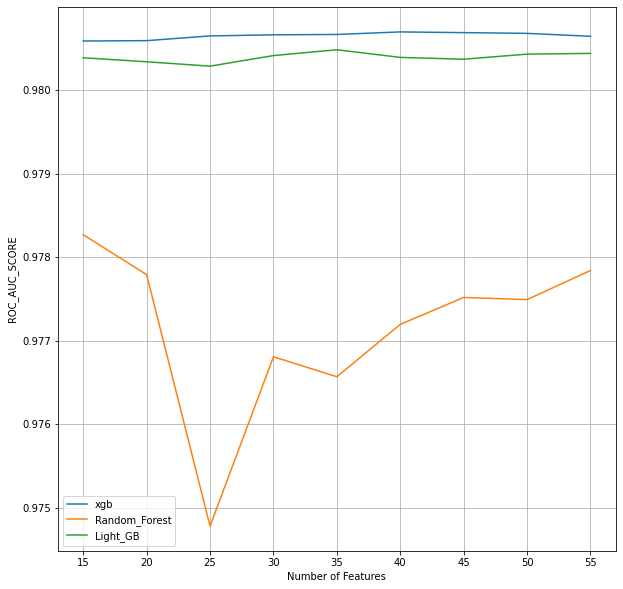

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(feature_no,xgb_AUC,label='xgb')
plt.plot(feature_no,rf_AUC,label='Random_Forest')
plt.plot(feature_no,lgb_AUC,label='Light_GB')
plt.legend()
plt.xlabel('Number of Features')
plt.ylabel('ROC_AUC_SCORE')
plt.title('Recursive Feature Elimination (Number of Features VS AUC_SCORE )')
plt.grid()
plt.show()   

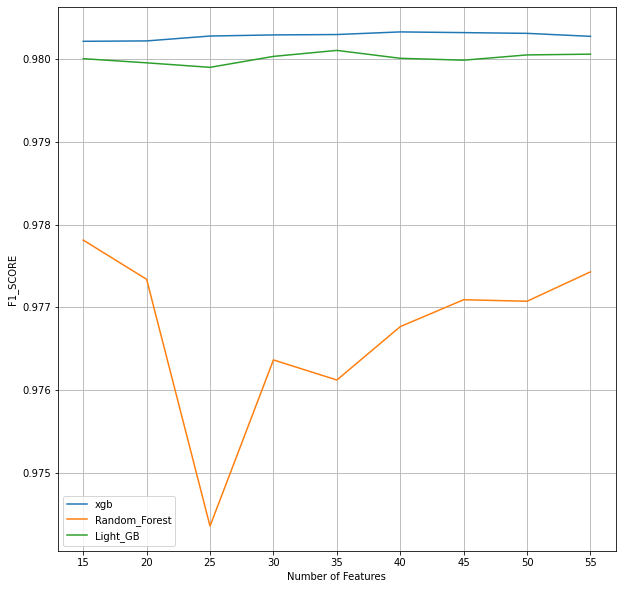

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(feature_no,xgb_f1,label='xgb')
plt.plot(feature_no,rf_f1,label='Random_Forest')
plt.plot(feature_no,lgb_f1,label='Light_GB')
plt.legend()
plt.xlabel('Number of Features')
plt.ylabel('F1_SCORE')
plt.title('Recursive Feature Elimination (Number of Features VS F1_SCORE )')
plt.grid()
plt.show()  

**OBSERVATIONS:**



*    **35-40** selected features showing highest AUC & F1_SCORE (**Model-XGB**)
*    **15** selected features showing highest AUC & F1_SCORE (**Model-Random_Forest**)
*   **30-40** selected features showing highest AUC & F1_SCORE (**Model-Light_GB**)


### **3.4 Feature Selection Using Filter Method (Statistical Method)**

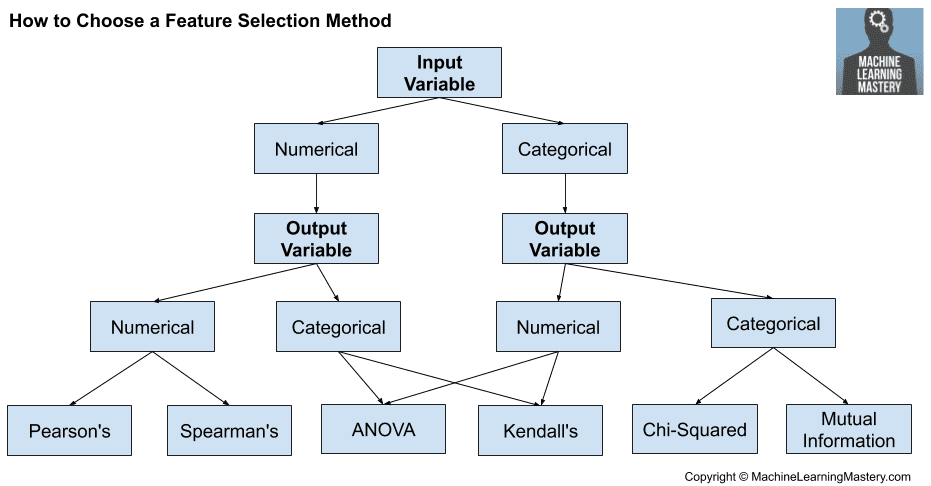

**3.4.1.Classification Feature Selection:(Numerical Input, Binary Output-ANOVA METHOD)**

In [ ]:
cont=list(meta_data[(meta_data['type']=='Continuous')]['column_name'])
numerical_input=[i for i in cont if i not in drop_list]
X_Numerical_input=X_Over[numerical_input]
y_train_target=Y_Over
print('Numerical feature shape:',X_Numerical_input.shape)
print('output length :',len(y_train_target))

Numerical feature shape: (1147036, 24)
output length : 1147036


In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

xgb_AUC=[]
rf_AUC=[]
lgb_AUC=[]
xgb_f1=[]
rf_f1=[]
lgb_f1=[]
feature_no=[4,8,12,16,20,24]
for i in feature_no :
    fs = SelectKBest(score_func=f_classif,k=i)
    X_selected = fs.fit_transform(X_Numerical_input, y_train_target)
    mask=fs.get_support()
    numerical_annova_selected_features = X_Numerical_input.columns[mask]
    X_train, X_test, y_train, y_test = train_test_split(X_Over[numerical_annova_selected_features], Y_Over, test_size=0.2, random_state=16)
    model_xgb1 = XGBClassifier(n_jobs=-1)
    model_rf1=RandomForestClassifier(n_jobs=-1)
    model_lgb1=LGBMClassifier(n_jobs=-1)

    model_xgb1.fit(X_train,y_train)
    model_rf1.fit(X_train,y_train)
    model_lgb1.fit(X_train,y_train)

    y_pred_xgb1 = model_xgb1.predict(X_test)
    y_pred_rf1 = model_rf1.predict(X_test)
    y_pred_lgb1 = model_lgb1.predict(X_test)

    xgb_AUC.append(roc_auc_score(y_test, y_pred_xgb1))
    rf_AUC.append(roc_auc_score(y_test, y_pred_rf1))
    lgb_AUC.append(roc_auc_score(y_test, y_pred_lgb1))
    
    xgb_f1.append(f1_score(y_test, y_pred_xgb1))
    rf_f1.append(f1_score(y_test, y_pred_rf1))
    lgb_f1.append(f1_score(y_test, y_pred_lgb1))

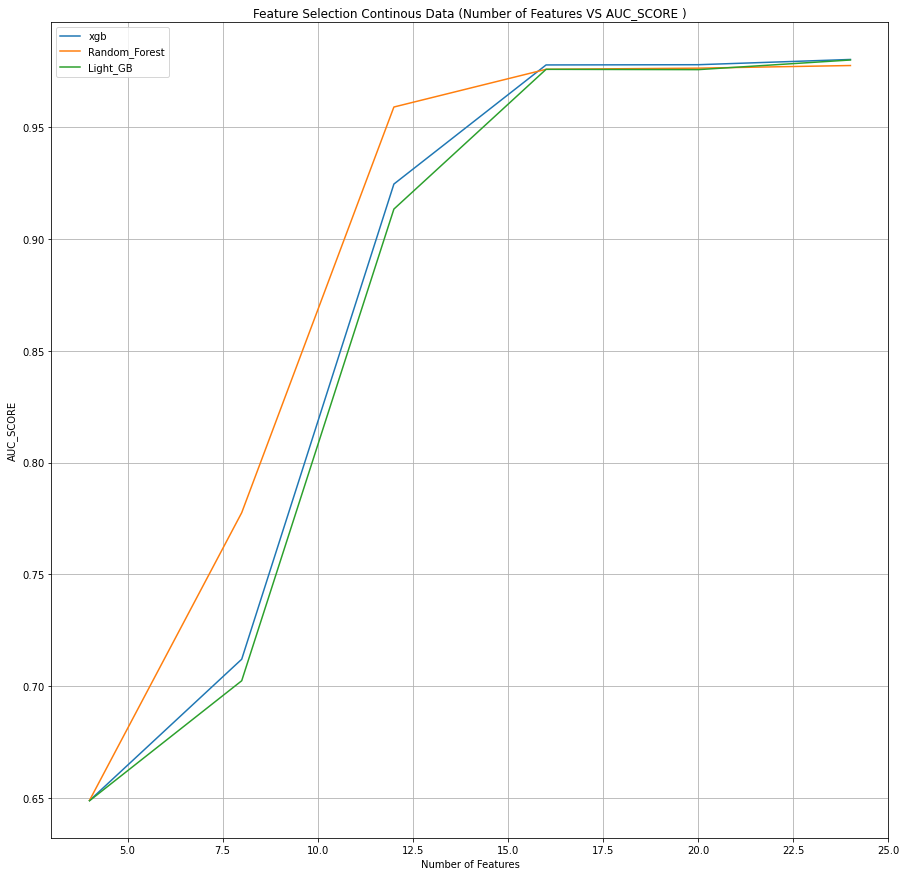

In [ ]:
plt.figure(figsize=(15,15))
plt.plot(feature_no,xgb_AUC,label='xgb')
plt.plot(feature_no,rf_AUC,label='Random_Forest')
plt.plot(feature_no,lgb_AUC,label='Light_GB')
plt.legend()
plt.xlabel('Number of Features')
plt.ylabel('AUC_SCORE')
plt.title('Feature Selection(ANOVA) Continous Value Features (Number of Features VS AUC_SCORE )')
plt.grid()
plt.show()   

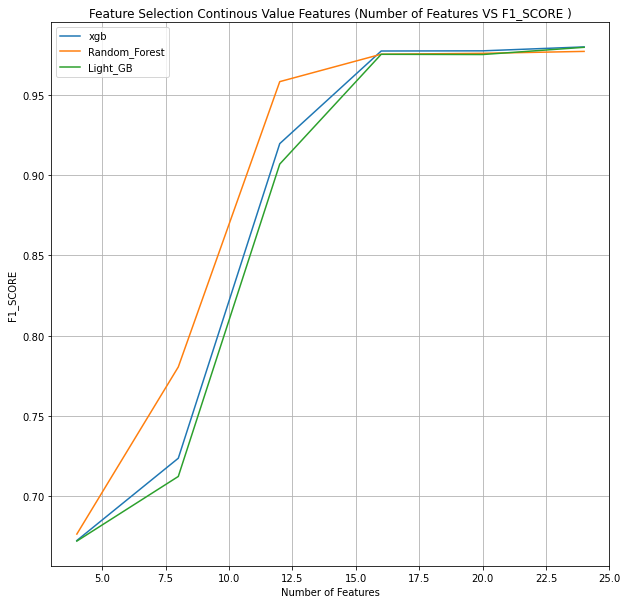

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(feature_no,xgb_f1,label='xgb')
plt.plot(feature_no,rf_f1,label='Random_Forest')
plt.plot(feature_no,lgb_f1,label='Light_GB')
plt.legend()
plt.xlabel('Number of Features')
plt.ylabel('F1_SCORE')
plt.title('Feature Selection(ANOVA) Continous Value Features (Number of Features VS F1_SCORE )')
plt.grid()
plt.show()  

**OBSERVATIONS:**



*    **16-17** selected continuous valued features showing highest AUC & F1_SCORE (**Model-XGB**)
*    **16-17** selected continuous valued features showing highest AUC & F1_SCORE (**Model-Random_Forest**)
*   **16-17** selected  continuous valued features showing highest AUC & F1_SCORE (**Model-Light_GB**)

**3.4.2 Classification Feature Selection:(categorical Input, Binary Output - MUTUAL INFORMATION METHOD)**

In [ ]:
cat=list(meta_data[(meta_data['type']=='Categorical') | (meta_data['type']=='Binary')]['column_name'])
cat.remove('id')
cat.remove('target')
categorical_input=[i for i in cat if i not in drop_list]
X_Categorical_input=X_Over[categorical_input]
y_train_target=Y_Over
print('Categorical feature shape:',X_Categorical_input.shape)
print('output length :',len(y_train_target))

Categorical feature shape: (1147036, 29)
output length : 1147036


In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif


xgb_AUC=[]
rf_AUC=[]
lgb_AUC=[]
xgb_f1=[]
rf_f1=[]
lgb_f1=[]
feature_no=[4,8,12,16,20,24,28]
for i in feature_no :
    fs_cat = SelectKBest(score_func=mutual_info_classif,k=i)
    fs_cat.fit_transform(X_Categorical_input, y_train_target)
    mask_cat=fs_cat.get_support()
    Categorical_selected_features = X_Categorical_input.columns[mask_cat]
    X_train, X_test, y_train, y_test = train_test_split(X_Over[Categorical_selected_features], Y_Over, test_size=0.2, random_state=20)
    model_xgb1 = XGBClassifier(n_jobs=-1)
    model_rf1=RandomForestClassifier(n_jobs=-1)
    model_lgb1=LGBMClassifier(n_jobs=-1)

    model_xgb1.fit(X_train,y_train)
    model_rf1.fit(X_train,y_train)
    model_lgb1.fit(X_train,y_train)

    y_pred_xgb1 = model_xgb1.predict(X_test)
    y_pred_rf1 = model_rf1.predict(X_test)
    y_pred_lgb1 = model_lgb1.predict(X_test)

    xgb_AUC.append(roc_auc_score(y_test, y_pred_xgb1))
    rf_AUC.append(roc_auc_score(y_test, y_pred_rf1))
    lgb_AUC.append(roc_auc_score(y_test, y_pred_lgb1))
    
    xgb_f1.append(f1_score(y_test, y_pred_xgb1))
    rf_f1.append(f1_score(y_test, y_pred_rf1))
    lgb_f1.append(f1_score(y_test, y_pred_lgb1))

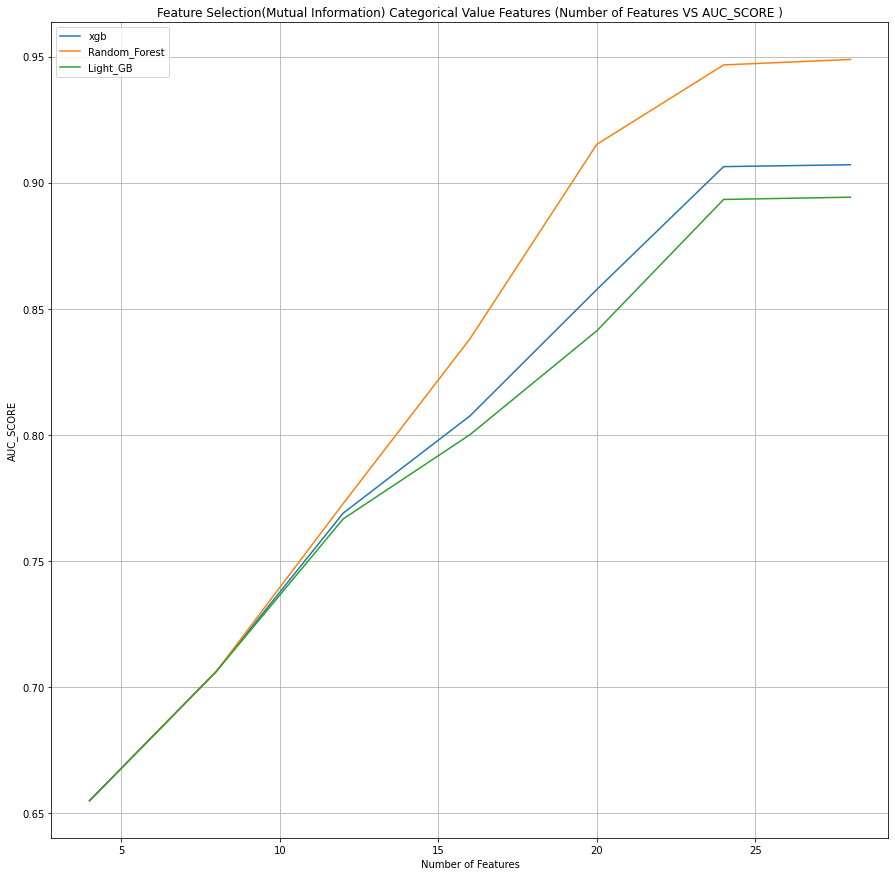

In [ ]:
plt.figure(figsize=(15,15))
plt.plot(feature_no,xgb_AUC,label='xgb')
plt.plot(feature_no,rf_AUC,label='Random_Forest')
plt.plot(feature_no,lgb_AUC,label='Light_GB')
plt.legend()
plt.xlabel('Number of Features')
plt.ylabel('AUC_SCORE')
plt.title('Feature Selection(Mutual Information) Categorical Value Features (Number of Features VS AUC_SCORE )')
plt.grid()
plt.show()  

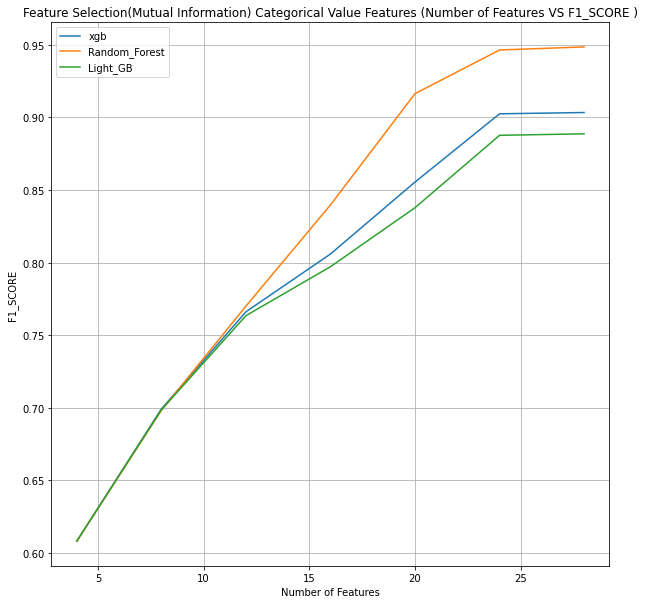

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(feature_no,xgb_f1,label='xgb')
plt.plot(feature_no,rf_f1,label='Random_Forest')
plt.plot(feature_no,lgb_f1,label='Light_GB')
plt.legend()
plt.xlabel('Number of Features')
plt.ylabel('F1_SCORE')
plt.title('Feature Selection(Mutual Information) Categorical Value Features (Number of Features VS F1_SCORE )')
plt.grid()
plt.show()  

**OBSERVATIONS:**



*    **23-24** selected categorical valued features showing highest AUC & F1_SCORE (**Model-XGB**)
*    **23-24** selected categorical valued features showing highest AUC & F1_SCORE (**Model-Random_Forest**)
*   **23-24** selected  categorical valued features showing highest AUC & F1_SCORE (**Model-Light_GB**)

## **4. Final Conclusion on Feature Selection:**



1.   **Total Featues** to be selected (defined by **Wrapper Method**-RFE): **40**
2.   **Total Featues** to be selected (defined by **Statistical Method**): 16+24=**40**
 *   **16 (ANOVA METHOD)**-Out of all Numerical **Continous Valued Features**
 *   **24 (MUTUAL INFORMATION METHOD)**- Out of all **Categorical Valued Features**





### **4.1 Selecting features(40) concluded by Wrapper Method**

In [ ]:
model_gbm = LGBMClassifier(n_jobs=-1)
rfe = RFE(model_gbm ,n_features_to_select=40)
fit = rfe.fit(X_Over,Y_Over)

df_RFE_results = []
for i in range(X_Over.shape[1]):
    df_RFE_results.append    (
                {      
            'Feature_names': X_Over.columns[i],
            'Selected':  rfe.support_[i],
            'RFE_ranking':  rfe.ranking_[i],
                }
                             )

df_RFE_results = pd.DataFrame(df_RFE_results)
df_RFE_results.index.name='Columns'
top_features_LGB=list(df_RFE_results[df_RFE_results['RFE_ranking']==1]['Feature_names'])
print('Top 40 features as per Wrapper Methods(light_GBM) are :\n',top_features_LGB)

Top 40 features as per Wrapper Methods(light_GBM) are :
 ['ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_15', 'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_12', 'ps_car_13', 'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_12', 'ps_calc_13', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin', 'ps_calc_20_bin']


In [ ]:
model_xgb = XGBClassifier(n_jobs=-1)
rfe = RFE(model_xgb ,n_features_to_select=40)
fit = rfe.fit(X_Over,Y_Over)

df_RFE_results = []
for i in range(X_Over.shape[1]):
    df_RFE_results.append    (
                {      
            'Feature_names': X_Over.columns[i],
            'Selected':  rfe.support_[i],
            'RFE_ranking':  rfe.ranking_[i],
                }
                             )

df_RFE_results = pd.DataFrame(df_RFE_results)
df_RFE_results.index.name='Columns'
top_features_XGB=list(df_RFE_results[df_RFE_results['RFE_ranking']==1]['Feature_names'])
print('Top 40 features as per Wrapper Methods(XGB) are :\n',top_features_XGB)

Top 40 features as per Wrapper Methods(XGB) are :
 ['ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_15', 'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01', 'ps_reg_02', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_11', 'ps_car_12', 'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09', 'ps_calc_12', 'ps_calc_13', 'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin', 'ps_calc_20_bin']


### **4.2 Selecting features concluded by Statistical Method**

**4.2.1 ANOVA (Continous valued features)**

In [ ]:
fs = SelectKBest(score_func=f_classif,k=16)
X_selected = fs.fit_transform(X_Numerical_input, y_train_target)
mask=fs.get_support()
numerical_annova_selected_features = X_Numerical_input.columns[mask]
print('Top 16 features as per ANOVA Method are :\n',numerical_annova_selected_features)

Top 16 features as per ANOVA Method are :
 Index(['ps_ind_15', 'ps_reg_01', 'ps_reg_02', 'ps_car_12', 'ps_car_13',
       'ps_car_15', 'ps_calc_04', 'ps_calc_05', 'ps_calc_06', 'ps_calc_07',
       'ps_calc_08', 'ps_calc_09', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13',
       'ps_calc_14'],
      dtype='object')


**4.2.2 MUTUAL INFORMATION (Categorical valued features)**

In [ ]:
fs_cat = SelectKBest(score_func=mutual_info_classif,k=24)
fs_cat.fit_transform(X_Categorical_input, y_train_target)
mask_cat=fs_cat.get_support()
Categorical_selected_features = X_Categorical_input.columns[mask_cat]
print('Top 24 features as per MUTUAL INFORMATION Method are :\n',Categorical_selected_features)

Top 24 features as per MUTUAL INFORMATION Method are :
 Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_06_bin', 'ps_ind_07_bin',
       'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_16_bin', 'ps_ind_17_bin',
       'ps_ind_18_bin', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_04_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat', 'ps_calc_15_bin', 'ps_calc_16_bin',
       'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin', 'ps_calc_20_bin'],
      dtype='object')
